In [13]:
import json
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
# Load paths from JSON file
with open('data_paths.json', 'r') as f:
    data_paths = json.load(f)
data_paths

{'train': '../data/processed/train',
 'val': '../data/processed/val',
 'test': '../data/processed/test'}

In [3]:
# Recreate data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data using the saved paths
train_generator = train_datagen.flow_from_directory(
    data_paths['train'],
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    data_paths['val'],
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    data_paths['test'],
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 14437 images belonging to 15 classes.
Found 3089 images belonging to 15 classes.
Found 3112 images belonging to 15 classes.


In [4]:
# Load the pre-trained ResNet50 model without the top layer
#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(15, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freese the base model
# Fine-tune
for layer in base_model.layers[:100]: # Unfreeze layers from index 100 onward
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

In [5]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    callbacks=[early_stopping]
)

Epoch 1/10
451/451 [==============================] - 518s 1s/step - loss: 1.6227 - accuracy: 0.5393 - val_loss: 1.6238 - val_accuracy: 0.5176
Epoch 2/10
451/451 [==============================] - 509s 1s/step - loss: 0.6555 - accuracy: 0.8135 - val_loss: 1.3004 - val_accuracy: 0.5957
Epoch 3/10
451/451 [==============================] - 519s 1s/step - loss: 0.4185 - accuracy: 0.8731 - val_loss: 1.1265 - val_accuracy: 0.6374
Epoch 4/10
451/451 [==============================] - 505s 1s/step - loss: 0.3109 - accuracy: 0.9014 - val_loss: 0.8859 - val_accuracy: 0.7093
Epoch 5/10
451/451 [==============================] - 491s 1s/step - loss: 0.2601 - accuracy: 0.9166 - val_loss: 0.7517 - val_accuracy: 0.7503
Epoch 6/10
451/451 [==============================] - 507s 1s/step - loss: 0.2142 - accuracy: 0.9309 - val_loss: 0.5825 - val_accuracy: 0.8079
Epoch 7/10
451/451 [==============================] - 497s 1s/step - loss: 0.1884 - accuracy: 0.9395 - val_loss: 0.4303 - val_accuracy: 0.8561

In [6]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

98/98 [==============================] - 22s 226ms/step - loss: 0.3199 - accuracy: 0.8924
Test Loss: 0.3199
Test Accuracy: 0.8924


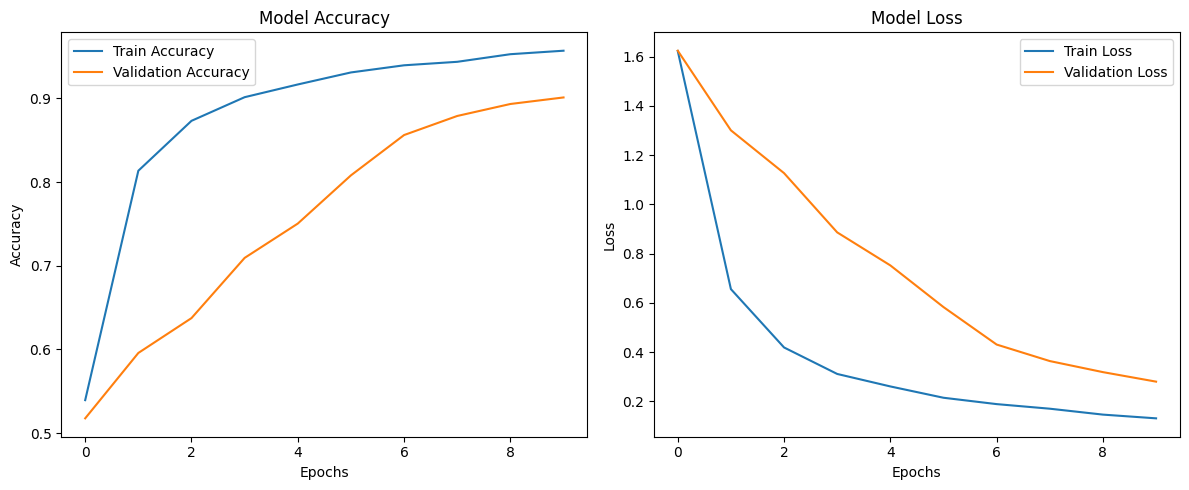

In [17]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('../plots/performance.png')
plt.show()

In [20]:
# Save the model
model.save('../models/plant_disease_model.keras')